In [10]:
!pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 55.0 MB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_io as tfio
import tensorflow as tf
import os

In [2]:
true_path = "/content/drive/MyDrive/archive/Parsed_Capuchinbird_Clips/XC114131-0.wav"
false_path = "/content/drive/MyDrive/archive/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav"

In [3]:
def load_audio_readable(filename):
    file = tf.io.read_file(filename)
    wave,rate = tf.audio.decode_wav(file,desired_channels=1)
    wave = tf.squeeze(wave,axis = -1)
    rate = tf.cast(rate,dtype=tf.int64)
    wave = tfio.audio.resample(wave,rate_in=rate,rate_out = 16000)
    return wave

In [4]:
wav = load_audio_readable(true_path)
wav2 = load_audio_readable(false_path)

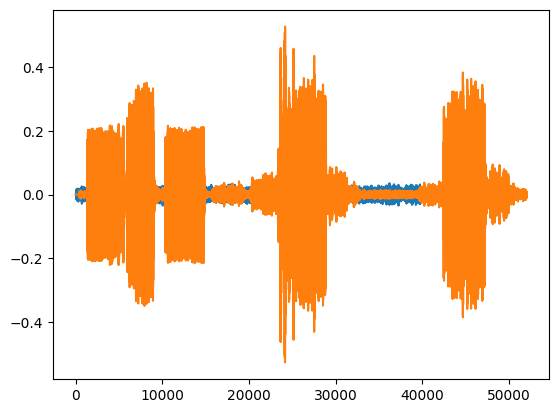

In [5]:
plt.plot(wav)
plt.plot(wav2)
plt.show()

In [25]:
true_path_d = "/content/drive/MyDrive/archive/Parsed_Capuchinbird_Clips"
false_path_d = "/content/drive/MyDrive/archive/Parsed_Not_Capuchinbird_Clips"

In [26]:
pos = tf.data.Dataset.list_files(true_path_d+"/*.wav")
neg = tf.data.Dataset.list_files(false_path_d+"/*.wav")

In [27]:
pos = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
neg = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = pos.concatenate(neg)

In [28]:
data = data.shuffle(200000)

In [11]:
def cal_length():
    import numpy as np
    lens = []
    for i in os.listdir(true_path_d):
        wave = load_audio_readable(os.path.join(true_path_d,i))
        lens.append(len(wave))
    return np.array(lens).mean(),lens

In [12]:
k,t=cal_length()

In [13]:
min(t)/16000,max(t)/16000,tf.reduce_mean(t)

(2.0, 5.0, <tf.Tensor: shape=(), dtype=int32, numpy=54156>)

In [30]:
def preprocess(file_path,label):
    wav = load_audio_readable(file_path)
    wav = wav[:48000]
    zeros_pad = tf.zeros([48000]-tf.shape(wav),dtype = tf.float32)
    wav = tf.concat([zeros_pad,wav],axis=0)
    spect = tf.signal.stft(wav,frame_length=320,frame_step = 32)
    spect = tf.abs(spect)
    spect = tf.expand_dims(spect,axis = 2)
    return spect,label


In [31]:
s,t = preprocess(true_path,1)


In [32]:
s

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       ...,

       [[6.1496712e-02],
        [6.2195774e-02],
        [6.0981087e-02],
        ...,
        [1.1465910e-05],
        [1.3461963e-05],
        [1.1995435e-05]],

       [[6.0565237e-02],
        [6.5492265e-02],
        [6.8888620e-02],
        ...,
        [6.9882640e-06],
        [3.5987678e-06],
        [1.0170043e-06]],

       [[4.3328911e-02],
        [5.7293948e-02],
        [6.8963550e-02],
        ...,
        [9.7474303

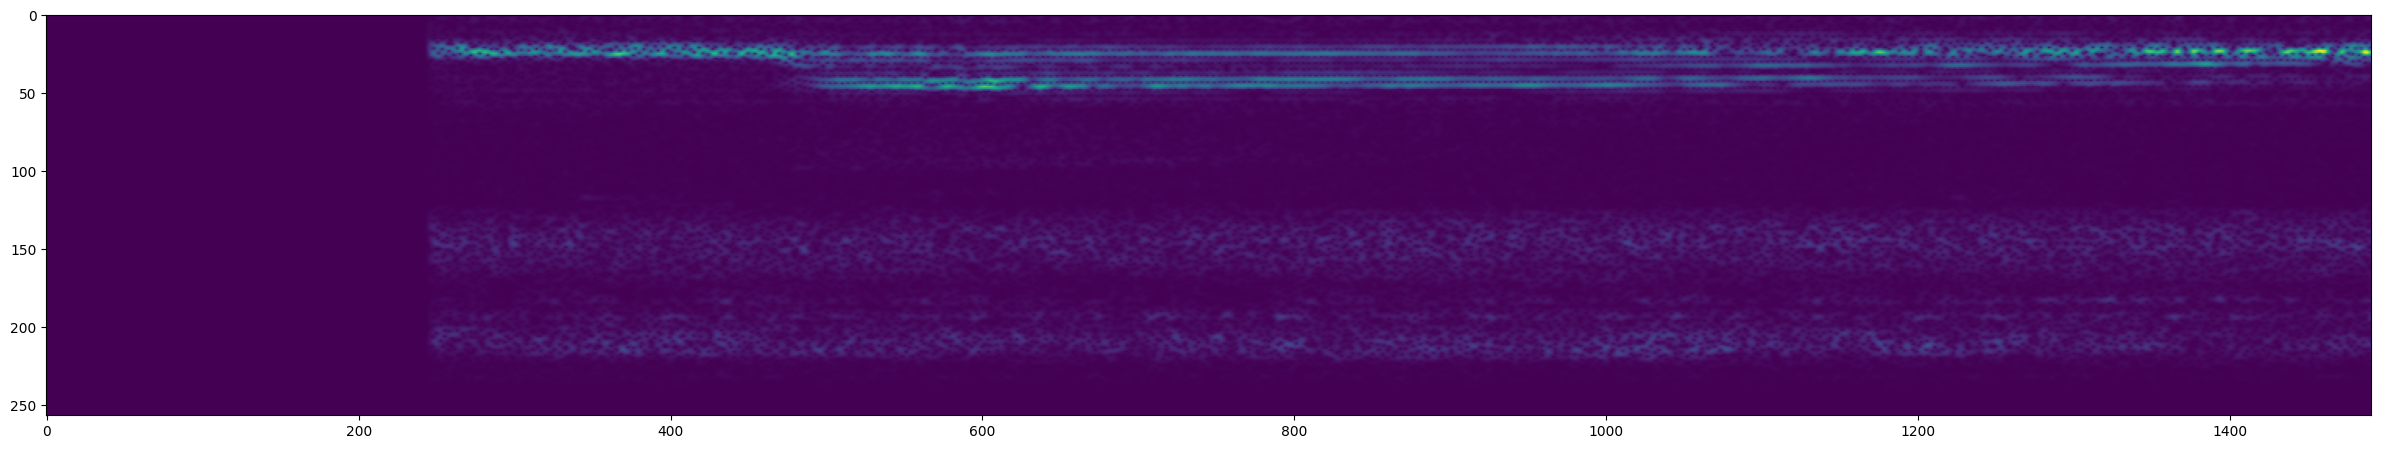

In [33]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(s)[0])
plt.show()

In [35]:
data = data.map(preprocess)

In [36]:
data.as_numpy_iterator().next()

(array([[[1.2490888e+00],
         [1.0034113e+00],
         [5.3928560e-01],
         ...,
         [3.5457513e-05],
         [3.1585641e-05],
         [1.0550022e-05]],
 
        [[1.2618721e+00],
         [9.6872383e-01],
         [4.3522227e-01],
         ...,
         [3.6979367e-05],
         [3.4333738e-05],
         [8.1658363e-06]],
 
        [[1.2953396e+00],
         [9.4817472e-01],
         [2.3973194e-01],
         ...,
         [1.9459843e-05],
         [3.5946214e-05],
         [2.0027161e-05]],
 
        ...,
 
        [[1.2995880e+00],
         [1.0715019e+00],
         [6.9365650e-01],
         ...,
         [4.7888632e-05],
         [4.9328813e-05],
         [2.0742416e-05]],
 
        [[1.3405621e+00],
         [1.1140517e+00],
         [6.7772865e-01],
         ...,
         [3.5879544e-05],
         [1.9052053e-05],
         [7.5697899e-06]],
 
        [[1.3417571e+00],
         [1.0566617e+00],
         [4.5041981e-01],
         ...,
         [7.3753028e-05],
  

In [37]:
data = data.cache()
data = data.shuffle(10000)
data = data.batch(16)
data = data.prefetch(8)

In [38]:
len(data)

51

In [39]:
train = data.take(36)
test = data.skip(36).take(15)

In [43]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16,(3,3),input_shape = (1491, 257, 1),activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(20,(3,3),activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation = "relu"))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

In [44]:
model.compile(optimizer = "Adam",loss = "BinaryCrossentropy",metrics = ["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 742, 125, 20)      2900      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 20)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 460040)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [46]:
hist = model.fit(train,epochs = 5,validation_data = test)

Epoch 1/5
36/36 [==============================] - 281s 123ms/step - loss: 1.1712 - accuracy: 0.9149 - recall_1: 0.8514 - precision_1: 0.8235 - val_loss: 0.0398 - val_accuracy: 0.9829 - val_recall_1: 0.9403 - val_precision_1: 1.0000
Epoch 2/5
36/36 [==============================] - 3s 88ms/step - loss: 0.0144 - accuracy: 0.9931 - recall_1: 0.9808 - precision_1: 0.9935 - val_loss: 0.0197 - val_accuracy: 0.9957 - val_recall_1: 0.9833 - val_precision_1: 1.0000
Epoch 3/5
36/36 [==============================] - 3s 93ms/step - loss: 0.0244 - accuracy: 0.9948 - recall_1: 0.9869 - precision_1: 0.9934 - val_loss: 0.0018 - val_accuracy: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 4/5
36/36 [==============================] - 3s 86ms/step - loss: 0.0022 - accuracy: 1.0000 - recall_1: 1.0000 - precision_1: 1.0000 - val_loss: 6.4390e-04 - val_accuracy: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 5/5
36/36 [==============================] - 3s 86ms/step - loss: 0

In [47]:
hist.history

{'loss': [1.171178936958313,
  0.014421705156564713,
  0.024409698322415352,
  0.0022259822580963373,
  0.019852496683597565],
 'accuracy': [0.9149305820465088,
  0.9930555820465088,
  0.9947916865348816,
  1.0,
  0.9965277910232544],
 'recall_1': [0.8513513803482056,
  0.9807692170143127,
  0.9869281053543091,
  1.0,
  0.9940476417541504],
 'precision_1': [0.8235294222831726,
  0.9935064911842346,
  0.9934210777282715,
  1.0,
  0.9940476417541504],
 'val_loss': [0.03975032642483711,
  0.019651494920253754,
  0.0018249406712129712,
  0.0006439039716497064,
  0.02535639889538288],
 'val_accuracy': [0.9829059839248657,
  0.995726466178894,
  1.0,
  1.0,
  0.995726466178894],
 'val_recall_1': [0.9402984976768494,
  0.9833333492279053,
  1.0,
  1.0,
  0.9846153855323792],
 'val_precision_1': [1.0, 1.0, 1.0, 1.0, 1.0]}

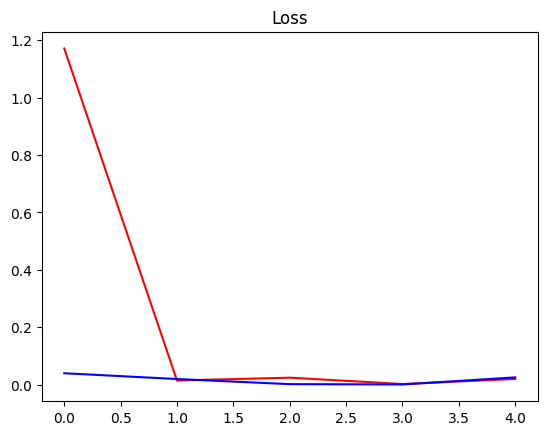

In [48]:
plt.title("Loss")
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

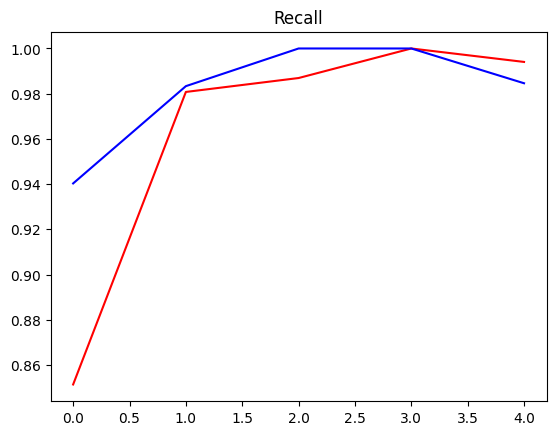

In [51]:
plt.title("Recall")
plt.plot(hist.history['recall_1'],'r')
plt.plot(hist.history['val_recall_1'],'b')
plt.show()

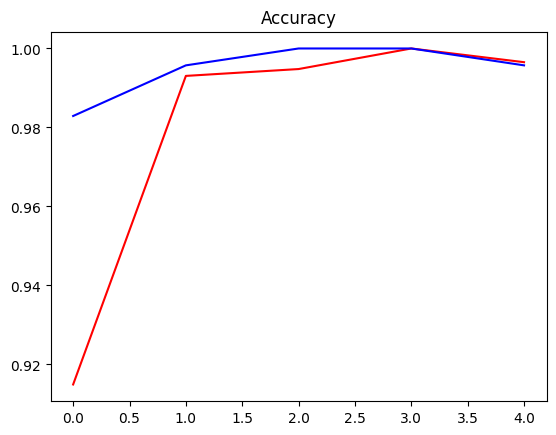

In [50]:
plt.title("Accuracy")
plt.plot(hist.history['accuracy'],'r')
plt.plot(hist.history['val_accuracy'],'b')
plt.show()

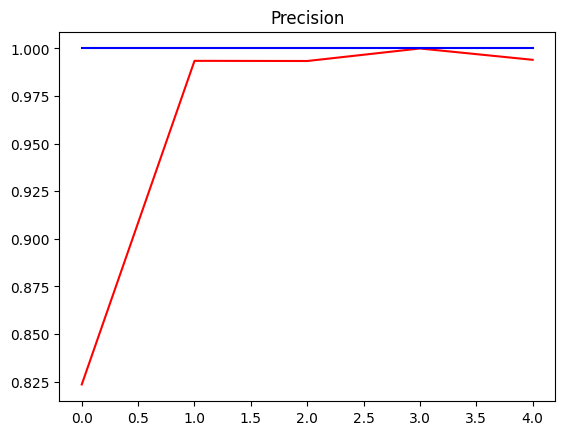

In [52]:
plt.title("Precision")
plt.plot(hist.history['precision_1'],'r')
plt.plot(hist.history['val_precision_1'],'b')
plt.show()

In [53]:
x_test,y_test = test.as_numpy_iterator().next()

In [54]:
pred = model.predict(x_test)

1/1 [==============================] - 0s 117ms/step


In [64]:
import numpy as np
k = np.squeeze((pred>0.5).astype(int),axis = 1)

In [60]:
y_test.astype(int)

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [65]:
k

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [66]:
k == y_test.astype(int)

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [67]:
def load_mp3_audio_readable(filename):
  res = tfio.audio.AudioIOTensor(filename)
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor,axis = 1)/2
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate,dtype=tf.int64)
  wav = tfio.audio.resample(tensor , rate_in = sample_rate,rate_out = 16000)
  return wav

In [68]:
vid = "/content/drive/MyDrive/archive/Forest Recordings/recording_00.mp3"

In [84]:
wav = load_mp3_audio_readable(vid)

In [85]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride = 48000,batch_size = 1)

In [86]:
sample,index = audio_slices.as_numpy_iterator().next()

In [87]:
sample[0]

array([ 8.1433272e-12, -5.7019250e-12, -5.3486417e-12, ...,
        6.2619494e-03, -1.5455363e-02, -8.7941047e-03], dtype=float32)

In [88]:
def preprocess_mp3(sample,label):
    sample = sample[0]
    zeros_pad = tf.zeros([48000]-tf.shape(sample),dtype = tf.float32)
    wav = tf.concat([zeros_pad,sample],axis=0)
    spect = tf.signal.stft(wav,frame_length=320,frame_step = 32)
    spect = tf.abs(spect)
    spect = tf.expand_dims(spect,axis = 2)
    return spect


In [89]:
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [90]:
pred = model.predict(audio_slices)

1/1 [==============================] - 3s 3s/step


In [93]:
pred = np.squeeze(pred,axis = 1)

In [103]:
pred = (pred>0.5).astype(int)

In [104]:
pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [98]:
    spect = tf.signal.stft(load_mp3_audio_readable(vid),frame_length=320,frame_step = 32)
    spect = tf.abs(spect)
    spect = tf.expand_dims(spect,axis = 2)

In [99]:
spect

<tf.Tensor: shape=(90011, 257, 1), dtype=float32, numpy=
array([[[2.38270040e-05],
        [2.64111677e-05],
        [2.55784362e-05],
        ...,
        [8.69513741e-08],
        [1.84566229e-08],
        [3.78104232e-08]],

       [[9.50916001e-06],
        [2.58965320e-05],
        [3.91917747e-05],
        ...,
        [1.55525854e-07],
        [2.91747888e-08],
        [1.14050636e-08]],

       [[2.83588906e-06],
        [2.40118261e-05],
        [4.54500841e-05],
        ...,
        [1.48127384e-07],
        [4.25209521e-08],
        [8.91759555e-09]],

       ...,

       [[7.06276894e-01],
        [5.79321623e-01],
        [3.12216908e-01],
        ...,
        [3.24711364e-05],
        [3.09582865e-05],
        [2.40504742e-05]],

       [[6.18013382e-01],
        [5.16692281e-01],
        [2.99451321e-01],
        ...,
        [3.53436008e-05],
        [2.71558893e-05],
        [8.10623169e-06]],

       [[4.95098263e-01],
        [4.21929389e-01],
        [2.54369527e-01

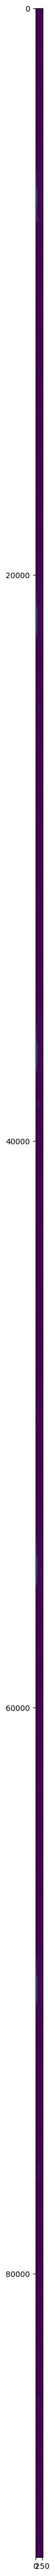

In [102]:
plt.figure(figsize=(50,60))
plt.imshow(spect)
plt.show()

In [107]:
from itertools import groupby
pred = [i for i,j in groupby(pred)]
no_of_calls = tf.reduce_sum(pred).numpy()
no_of_calls

5

In [108]:
final = {}
for i in os.listdir("/content/drive/MyDrive/archive/Forest Recordings"):
  filename = os.path.join("/content/drive/MyDrive/archive/Forest Recordings",i)

  wav = load_mp3_audio_readable(filename)
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav,48000,48000,batch_size = 1)
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)

  pred = model.predict(audio_slices)
  final[i] = pred

1/1 [==============================] - 2s 2s/step


In [111]:
classes = {}
for i,j in final.items():
  j = np.squeeze(j,axis = 1)
  j = (j>0.9).astype(int)
  classes[i] = tf.reduce_sum([k for k,g in groupby(j)]).numpy()
classes

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 23,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_19.mp3': 0,
 'recording_18.mp3': 4,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_27.mp3': 0,
 'recording_26.mp3': 2,
 'recording_25.mp3': 17,
 'recording_24.mp3': 0,
 'recording_29.mp3': 0,
 'recording_28.mp3': 16,
 'recording_30.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_35.mp3': 0,
 'recording_34.mp3': 4,
 'recording_37.mp3': 3,
 'recording_36.mp3': 0,
 'recording_38.mp3': 1,
 'recording_41.mp3': 0,
 'recording_39.mp3': 12,
 'recording_

In [112]:
import csv

In [113]:
with open("bird_density.csv","w",newline="") as f:
  writer = csv.writer(f,delimiter='r')
  writer.writerow(['recording','no_of_calls'])
  for k,val in classes.items():
    writer.writerow([k,val])

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("bird_density.csv")

In [4]:
df

,recordingrno_of_calls
0,recording_00.mp3r5
1,recording_01.mp3r0
2,recording_02.mp3r0
3,recording_03.mp3r0
4,recording_04.mp3r4
...,...
95,recording_95.mp3r3
96,recording_97.mp3r4
97,recording_96.mp3r1
98,recording_98.mp3r20
